# **Regression Trees**

Maintainer: Zhaohu(Jonathan) Fan.Contact him at (psujohnny@gmail.com)

Note: This lab note is still WIP, let us know if you encounter bugs or issues.

*Acknowledgments: I have drawn ideas or readings from the following materials:*

-  [Post pruning decision trees with cost complexity pruning](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html)


# Table of Contents

1. [CART: classification and regression trees](#1-cart-classification-and-regression-trees)  
   1.1 [Regression Trees (Boston Housing Data)](#11-regression-trees-boston-housing-data)  
   1.1.1 [Printing and ploting the tree](#111-printing-and-ploting-the-tree)  
   1.1.2 [Prediction using regression trees](#112-prediction-using-regression-trees)  
   1.1.3 [Comparing the performance of regression trees with linear regression model in terms of prediction error (Exercise)](#113-comparing-the-performance-of-regression-trees-with-linear-regression-model-in-terms-of-prediction-error-exercise)  
   1.2 [Pruning](#12-pruning)  


#### *Colab Notebook [Open in Colab](https://colab.research.google.com/drive/1d6PHj_B9qmLJ0RtaIpyEXI8OUu6GdpH0?usp=sharing)*

#### *Useful information about [Regression Trees in R](https://yanyudm.github.io/Data-Mining-R/lecture/6.A_RegTree.html)*




# 1 CART: classification and regression trees
CART stands for classification and regression trees:

- Regression trees: response variable Y is numerical
- Classification trees: response variable Y is categorical

For the regression trees example, we will use the Boston Housing data. Recall the response variable is the housing price. For the classification trees example, we will use the credit scoring data. The response variable is whether the loan went to default.

Note that unlike logistic regreesion, the response variable does not have to be binary in case of classification trees. We can use classification trees on classification problems with more than 2 outcomes.




## 1.1 Regression Trees (Boston Housing Data)

Let us load the data sets. Random sampled training and test datasets will lead to different results,



In [17]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [18]:
# ------------------------------------------------------------
# Python (Google Colab) equivalent of the R CART regression-tree code
# UPDATED: Load Boston Housing data from:
#   data_url = "http://lib.stat.cmu.edu/datasets/boston"
# and use StandardScaler (for the linear regression baseline).
# ------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 1) Load Boston Housing data (CMU URL)
#   The CMU file stores each observation across two rows.
# -----------------------------
data_url = "http://lib.stat.cmu.edu/datasets/boston"

raw_df = pd.read_csv(data_url, sep=r"\s+", skiprows=22, header=None)

# Combine two lines per observation:
# - features: first row has 11 cols, second row has first 2 cols  -> total 13 features
# - target: second row's 3rd col (index 2) -> MEDV
X_np = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y_np = raw_df.values[1::2, 2]

columns = ["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX","PTRATIO","B","LSTAT"]
df = pd.DataFrame(X_np, columns=columns)
df["medv"] = y_np

print("Boston data shape:", df.shape)
display(df.head())



Boston data shape: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,medv
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [7]:
# -----------------------------
# 2) Train/test split (90/10)
# -----------------------------
X = df.drop(columns=["medv"])
y = df["medv"].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=123, shuffle=True
)

print(f"\nTrain: X={X_train.shape}, y={y_train.shape}")
print(f"Test : X={X_test.shape},  y={y_test.shape}")




Train: X=(455, 13), y=(455,)
Test : X=(51, 13),  y=(51,)


### 1.1.1 Printing and ploting the tree


--- Regression tree (text view, first 4 levels) ---
|--- RM <= 6.98
|   |--- LSTAT <= 15.00
|   |   |--- RM <= 6.54
|   |   |   |--- DIS <= 1.42
|   |   |   |   |--- value: [50.00]
|   |   |   |--- DIS >  1.42
|   |   |   |   |--- truncated branch of depth 18
|   |   |--- RM >  6.54
|   |   |   |--- LSTAT <= 4.91
|   |   |   |   |--- truncated branch of depth 8
|   |   |   |--- LSTAT >  4.91
|   |   |   |   |--- truncated branch of depth 9
|   |--- LSTAT >  15.00
|   |   |--- CRIM <= 5.77
|   |   |   |--- NOX <= 0.53
|   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- NOX >  0.53
|   |   |   |   |--- truncated branch of depth 15
|   |   |--- CRIM >  5.77
|   |   |   |--- NOX <= 0.61
|   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- NOX >  0.61
|   |   |   |   |--- truncated branch of depth 11
|--- RM >  6.98
|   |--- RM <= 7.44
|   |   |--- DIS <= 1.55
|   |   |   |--- value: [50.00]
|   |   |--- DIS >  1.55
|   |   |   |--- CRIM <= 5.19
|   |   |   |   |

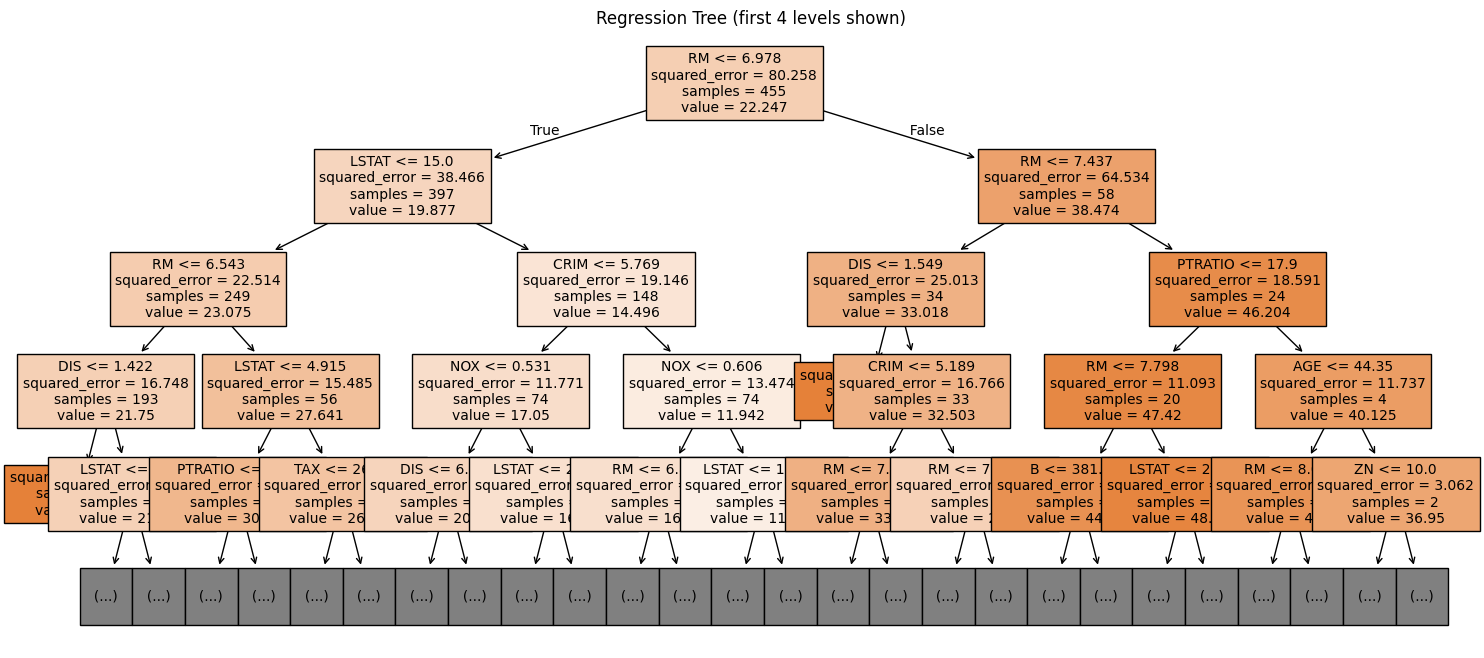


MSE  (tree, train): 0.0000
MSPE (tree, test) : 95.5276


In [10]:
# -----------------------------
# 3) Regression tree (default)
#   R: boston_rpart <- rpart(medv ~ ., data=boston_train)
# -----------------------------
boston_tree = DecisionTreeRegressor(random_state=123)
boston_tree.fit(X_train, y_train)

print("\n--- Regression tree (text view, first 4 levels) ---")
print(export_text(boston_tree, feature_names=list(X.columns), max_depth=3))

# Plot a readable version (full tree can be very large)
plt.figure(figsize=(18, 8))
plot_tree(
    boston_tree,
    feature_names=list(X.columns),
    filled=True,
    max_depth=4,
    fontsize=10
)
plt.title("Regression Tree (first 4 levels shown)")
plt.show()

# Predictions + errors
yhat_train_tree = boston_tree.predict(X_train)
yhat_test_tree  = boston_tree.predict(X_test)

MSE_tree  = mean_squared_error(y_train, yhat_train_tree)  # in-sample
MSPE_tree = mean_squared_error(y_test,  yhat_test_tree)   # out-of-sample

print(f"\nMSE  (tree, train): {MSE_tree:.4f}")
print(f"MSPE (tree, test) : {MSPE_tree:.4f}")


Make sure you know how to interpret this tree model!

Exercise: What is the predicted median housing price (in thousand) given following information:
| crim | zn | indus | chas | nox | rm  | age  | dis  | rad | tax | ptratio | black  | lstat | medv |
|------|----|-------|------|-----|-----|------|------|-----|-----|---------|--------|-------|------|
| 0.09 | 0  | 25.65 | 0    | 0.58| 5.96| 92.9 | 2.09 | 2   | 188 | 19.1    | 378.09 | 17.93 | 20.5 |


### 1.1.2 Prediction using regression trees





The in-sample and out-of-sample prediction for regression trees is also similar to lm and glm models.

* In-sample prediction
* Out-of-sample prediction

We often denote MSE as training error, and MSPE as testing error when sample size is large.

**Exercise:** Calculate the mean squared error (MSE) for this tree model

In [29]:
# -----------------------------
# 4) Linear regression baseline (with StandardScaler)
#   R: boston.reg <- lm(medv ~ ., data=boston_train)
#
# Scaling is not required for OLS.
# -----------------------------
boston_lm = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("model", LinearRegression())
])
boston_lm.fit(X_train, y_train)

yhat_train_lm = boston_lm.predict(X_train)
yhat_test_lm  = boston_lm.predict(X_test)

MSE_lm  = mean_squared_error(y_train, yhat_train_lm)
MSPE_lm = mean_squared_error(y_test,  yhat_test_lm)

print(f"\nMSE  (linear regression, train): {MSE_lm:.4f}")
print(f"MSPE (linear regression, test) : {MSPE_lm:.4f}")




MSE  (linear regression, train): 19.9707
MSPE (linear regression, test) : 41.0188


### 1.1.3 Comparing the performance of regression trees with linear regression model in terms of prediction error (Exercise)


In [28]:

# mean((boston_test_pred_reg - boston_test$medv)^2)
print("\nCheck (MSPE from explicit formula):",
      f"{np.mean((yhat_test_lm - y_test.values) ** 2):.4f}")


Check (MSPE from explicit formula): 41.0188


## 1.2 Pruning

In Python’s `DecisionTreeRegressor`, the `ccp_alpha` parameter controls tree complexity via **cost-complexity pruning**. It penalizes larger trees by adding a term proportional to the number of leaves. A smaller `ccp_alpha` produces a larger (more complex) tree, while a larger `ccp_alpha` results in a more heavily pruned (simpler) tree.


In [21]:

# -----------------------------
# 5) Grow a "large tree" (less pruning)
#   R: boston_largetree <- rpart(..., cp=0.001)
#
# In sklearn, post-pruning is controlled by ccp_alpha:
#   smaller ccp_alpha => larger/more complex tree
# (Not numerically identical to rpart cp, but similar role.)
# -----------------------------
boston_largetree = DecisionTreeRegressor(random_state=123, ccp_alpha=0.001)
boston_largetree.fit(X_train, y_train)

print("\nLarge tree depth:", boston_largetree.get_depth(),
      "| leaves:", boston_largetree.get_n_leaves())


Large tree depth: 18 | leaves: 268


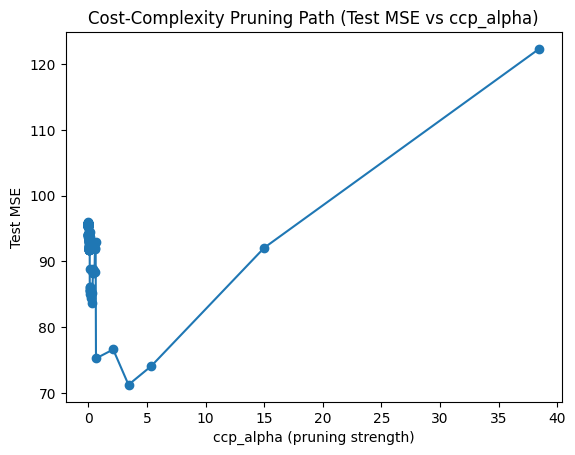

,ccp_alpha,train_MSE,test_MSE,depth,leaves
0,0.000000e+00,0.000000,95.527647,21,431
1,2.498612e-16,0.000000,95.527647,21,430
2,1.098901e-05,0.000022,95.527647,21,428
3,1.098901e-05,0.000022,95.527647,21,428
4,1.098901e-05,0.000055,95.528088,21,425
5,1.098901e-05,0.000055,95.528088,21,425
6,1.098901e-05,0.000055,95.528088,21,425
7,1.098901e-05,0.000066,95.525000,21,424
8,1.098901e-05,0.000187,95.526520,21,413
9,1.098901e-05,0.000187,95.526520,21,413



Baseline (predict mean) MSE on TRAIN: 80.2579


In [22]:

# -----------------------------
# 6) plotcp / printcp analogue: pruning path via ccp_alpha
#   R: plotcp(boston_largetree); printcp(boston_largetree)
# -----------------------------
path = boston_largetree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

train_mse = []
test_mse = []
trees = []

for a in ccp_alphas:
    t = DecisionTreeRegressor(random_state=123, ccp_alpha=a)
    t.fit(X_train, y_train)
    trees.append(t)
    train_mse.append(mean_squared_error(y_train, t.predict(X_train)))
    test_mse.append(mean_squared_error(y_test,  t.predict(X_test)))

train_mse = np.array(train_mse)
test_mse  = np.array(test_mse)

plt.figure()
plt.plot(ccp_alphas, test_mse, marker="o")
plt.xlabel("ccp_alpha (pruning strength)")
plt.ylabel("Test MSE")
plt.title("Cost-Complexity Pruning Path (Test MSE vs ccp_alpha)")
plt.show()

prune_table = pd.DataFrame({
    "ccp_alpha": ccp_alphas,
    "train_MSE": train_mse,
    "test_MSE": test_mse,
    "depth": [t.get_depth() for t in trees],
    "leaves": [t.get_n_leaves() for t in trees],
})
display(prune_table.head(10))

# R line: sum((y - mean(y))^2)/nrow(train)  (variance around the mean)
train_baseline_mse = np.mean((y_train - y_train.mean()) ** 2)
print("\nBaseline (predict mean) MSE on TRAIN:", f"{train_baseline_mse:.4f}")


In [24]:
# -----------------------------
# 7) Prune at a specific level (analogue of prune(..., cp=0.008))
# In sklearn: choose a ccp_alpha. Here we pick the closest available alpha to 0.008.
# -----------------------------
target_alpha = 0.008
alpha_star = float(ccp_alphas[np.argmin(np.abs(ccp_alphas - target_alpha))])

boston_pruned = DecisionTreeRegressor(random_state=123, ccp_alpha=alpha_star)
boston_pruned.fit(X_train, y_train)

print(f"\nRequested prune level ~ {target_alpha}; using closest ccp_alpha = {alpha_star:.6g}")
print("Pruned tree depth:", boston_pruned.get_depth(),
      "| leaves:", boston_pruned.get_n_leaves())

print("Pruned tree MSPE (test):",
      f"{mean_squared_error(y_test, boston_pruned.predict(X_test)):.4f}")


Requested prune level ~ 0.008; using closest ccp_alpha = 0.00799676
Pruned tree depth: 16 | leaves: 146
Pruned tree MSPE (test): 95.8757


## Interpreting the Pruning Results (Short)

### `alpha_min` vs `alpha_1se`
- **`alpha_min`** is the `ccp_alpha` that gives the **smallest mean 10-fold CV MSE** on the training set.  
- **`alpha_1se`** uses the **1-SE rule**: choose the **simplest** tree whose CV MSE is still within

$$
\text{threshold} = \text{min CV MSE} + \text{SE at the minimum}.
$$

In practice, “simplest” means the **largest `ccp_alpha`** (most pruning) that stays below the threshold.

### Test MSE
- **`Test MSE (pruned @ alpha_1se)`** is the **out-of-sample** error on the test set.
- It can be much larger than CV MSE because a single test split can be noisy; CV averages over folds.

### Table columns (printcp-like)
- `rel_error (train)` = train MSE / root-node error (predicting the mean).  
- `xerror (CV)` and `xstd (CV)` = CV mean error and its SE (both scaled by root-node error).  
- Large `depth/leaves` + tiny training error indicates **overfitting**; use **CV error** to choose pruning.


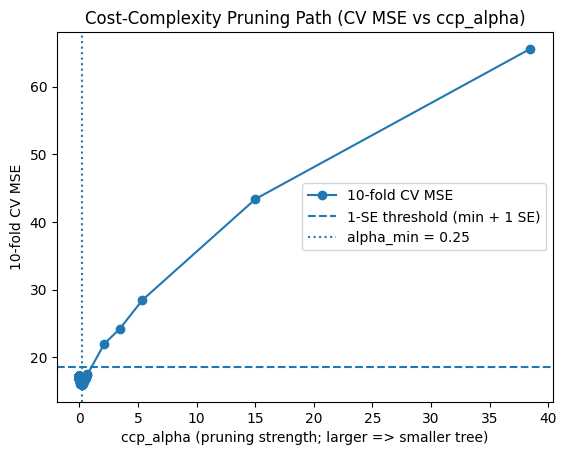

alpha_min (min CV MSE): 0.246937 | CV MSE=15.9351
alpha_1se (1-SE rule):  0.653054 | threshold=18.5049
Test MSE (pruned @ alpha_1se): 75.2203


,ccp_alpha,nsplit (≈),rel_error (train),xerror (CV),xstd (CV),depth,leaves
0,0.000000e+00,430,0.000000e+00,0.214178,0.021182,21,431
1,2.498612e-16,429,0.000000e+00,0.214178,0.021182,21,430
2,1.098901e-05,427,2.738424e-07,0.214178,0.021182,21,428
3,1.098901e-05,427,2.738424e-07,0.214178,0.021182,21,428
4,1.098901e-05,424,6.846060e-07,0.214178,0.021182,21,425
5,1.098901e-05,424,6.846060e-07,0.214178,0.021182,21,425
6,1.098901e-05,424,6.846060e-07,0.214178,0.021182,21,425
7,1.098901e-05,423,8.215272e-07,0.214178,0.021182,21,424
8,1.098901e-05,412,2.327660e-06,0.214178,0.021182,21,413
9,1.098901e-05,412,2.327660e-06,0.214178,0.021182,21,413


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

# 1) Candidate alphas from a large tree
boston_largetree = DecisionTreeRegressor(random_state=123, ccp_alpha=0.0)
boston_largetree.fit(X_train, y_train)

path = boston_largetree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# 2) 10-fold CV on training set (plotcp / xerror analogue)
kf = KFold(n_splits=10, shuffle=True, random_state=123)

cv_mean_mse = []
cv_se_mse = []
train_mse = []
trees = []

for a in ccp_alphas:
    t = DecisionTreeRegressor(random_state=123, ccp_alpha=a)

    # CV MSE (neg_mean_squared_error -> multiply by -1)
    scores = cross_val_score(t, X_train, y_train, cv=kf, scoring="neg_mean_squared_error")
    mse_scores = -scores
    cv_mean_mse.append(mse_scores.mean())
    cv_se_mse.append(mse_scores.std(ddof=1) / np.sqrt(len(mse_scores)))

    # Fit once for in-sample MSE + size info
    t.fit(X_train, y_train)
    trees.append(t)
    train_mse.append(mean_squared_error(y_train, t.predict(X_train)))

cv_mean_mse = np.array(cv_mean_mse)
cv_se_mse = np.array(cv_se_mse)
train_mse = np.array(train_mse)

# 3) Plot CV MSE vs ccp_alpha with 1-SE line (plotcp-like)
min_idx = int(np.argmin(cv_mean_mse))
alpha_min = float(ccp_alphas[min_idx])
min_mse = float(cv_mean_mse[min_idx])
min_se = float(cv_se_mse[min_idx])

threshold = min_mse + min_se

plt.figure()
plt.plot(ccp_alphas, cv_mean_mse, marker="o", label="10-fold CV MSE")
plt.axhline(threshold, linestyle="--", label="1-SE threshold (min + 1 SE)")
plt.axvline(alpha_min, linestyle=":", label=f"alpha_min = {alpha_min:.2g}")
plt.xlabel("ccp_alpha (pruning strength; larger => smaller tree)")
plt.ylabel("10-fold CV MSE")
plt.title("Cost-Complexity Pruning Path (CV MSE vs ccp_alpha)")
plt.legend()
plt.show()

# 4) 1-SE rule: choose the most pruned (largest alpha) within threshold
eligible = np.where(cv_mean_mse <= threshold)[0]
alpha_1se = float(ccp_alphas[eligible.max()])

print(f"alpha_min (min CV MSE): {alpha_min:.6g} | CV MSE={min_mse:.4f}")
print(f"alpha_1se (1-SE rule):  {alpha_1se:.6g} | threshold={threshold:.4f}")

# 5) Refit pruned tree at alpha_1se and evaluate on test set once
boston_pruned = DecisionTreeRegressor(random_state=123, ccp_alpha=alpha_1se)
boston_pruned.fit(X_train, y_train)

test_mse_pruned = mean_squared_error(y_test, boston_pruned.predict(X_test))
print(f"Test MSE (pruned @ alpha_1se): {test_mse_pruned:.4f}")

# 6) "printcp" analogue table
root_node_error = np.mean((y_train - y_train.mean()) ** 2)

prune_table = pd.DataFrame({
    "ccp_alpha": ccp_alphas,
    "nsplit (≈)": [t.get_n_leaves() - 1 for t in trees],
    "rel_error (train)": train_mse / root_node_error,
    "xerror (CV)": cv_mean_mse / root_node_error,
    "xstd (CV)": cv_se_mse / root_node_error,
    "depth": [t.get_depth() for t in trees],
    "leaves": [t.get_n_leaves() for t in trees],
})
display(prune_table.head(15))


### Pruning

For more details, see the scikit-learn example:
https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

Here we use **cost-complexity pruning**. Minimal cost-complexity pruning (also called *weakest-link pruning*) recursively removes the subtree that provides the smallest improvement per unit of added complexity. Each internal node can be associated with an **effective alpha** value, and nodes with the smallest effective alpha are pruned first.

To explore reasonable pruning levels, scikit-learn provides  
`DecisionTreeRegressor.cost_complexity_pruning_path(X, y)`, which returns:

- a sequence of candidate `ccp_alpha` values (effective alphas), and  
- the corresponding total leaf impurities at each pruning step.

As `ccp_alpha` increases, the complexity penalty becomes stronger, so **more of the tree is pruned**. This typically produces a **smaller** tree (fewer leaves) and increases the total leaf impurity.

In scikit-learn’s `DecisionTreeRegressor`, the `ccp_alpha` parameter controls complexity via the **cost-complexity objective**:

$$
R_{\alpha}(T) = R(T) + \alpha \, |T|
$$

where $R(T)$ is the within-leaf impurity (for regression, based on squared error) and $|T|$ is the number of leaves.  
Therefore:

- Smaller `ccp_alpha` $\rightarrow$ weaker penalty $\rightarrow$ **larger (more complex) tree**  
- Larger `ccp_alpha` $\rightarrow$ stronger penalty $\rightarrow$ **smaller (more pruned) tree**

**Note:** This differs from R’s `rpart` parameter `cp`. In `rpart`, `cp` acts like a *pre-pruning* threshold that can prevent certain splits from being made. In scikit-learn, `ccp_alpha` is used for *post-pruning* (selecting a subtree after a large tree is grown).


**How to choose `ccp_alpha` (analogue of the `plotcp()` rule of thumb in R):**  
In R’s `plotcp()`, a common heuristic is to choose the *leftmost* tree whose mean cross-validation error is below the horizontal line (the “1-SE” line), which favors a simpler tree that performs nearly as well as the best one.  

In Python, we can use the same idea: compute cross-validated MSE for each candidate `ccp_alpha`, find the minimum CV MSE, then choose the **largest `ccp_alpha`** (i.e., the **most pruned / simplest tree**) whose CV MSE is within **one standard error** of the minimum. This is often called the **1-SE rule**.


In [ ]:
%%shell
jupyter nbconvert --to html ///content/6_A_Regression_Trees.ipynb

[NbConvertApp] Converting notebook ///content/6_A_Regression_Trees.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 652734 bytes to /content/6_A_Regression_Trees.html
